In [1]:
#Librairies necessary for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame
from pandas import concat
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [2]:
#Read the csv, use date column as a datetime index
df = pd.read_csv(r"/home/chinchin/Bureau/prog/Python/ogoxi/csv/Gironde Adour Dordogne/dronne_merged.csv", sep=";", parse_dates=['Date'], index_col="Date")

std:
P8312510    28.726666
P8394310    29.793946
P8462510    30.135183
P8022520    14.316794
P8102520    17.350757
dtype: float64
mean:
P8312510    117.697730
P8394310     67.249053
P8462510     40.517414
P8022520     -9.999520
P8102520     56.536702
dtype: float64


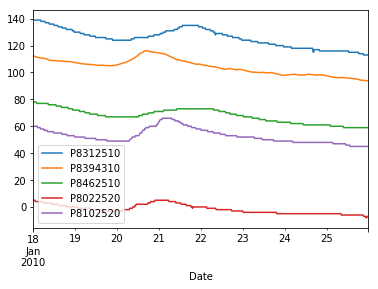

In [3]:
#Data resample on a 10 minutes step
resampled_df = df.resample('15T').mean()
#Fill the holes with time interpolation
interpolate_df = resampled_df.interpolate(method="time")
#Drop very first rows where interpolation cannot be possible
interpolate_df = interpolate_df.dropna()
#Scale the data
scaler = StandardScaler()
scalar_numpy = scaler.fit_transform(interpolate_df)
#Create a new dataset with the scaled data
scalar_df = pd.DataFrame(data=scalar_numpy, index=interpolate_df.index.values, columns=interpolate_df.columns.values)

#Plots----------------------------------------------
#df['2010-01-18':'2010-01-25'].plot()
#resampled_df['2010-01-18':'2010-01-25'].plot()
interpolate_df['2010-01-18':'2010-01-25'].plot()
#scalar_df['2010-01-18':'2010-01-25'].plot()

print("std:")
print(np.sqrt(np.var(interpolate_df)))
print("mean:")
print(np.mean(interpolate_df))


In [4]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, -1, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    cols.append(df.shift(-n_out))
    names += [('var%d(t+%d)' % (j+1, n_out)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


#---------------------------------------
time_lag_df = series_to_supervised(scalar_df, 8, 2, True)


i=0
for columns in time_lag_df :   
    print(i)
    print(columns)
    i = i+1

0
var1(t-8)
1
var2(t-8)
2
var3(t-8)
3
var4(t-8)
4
var5(t-8)
5
var1(t-7)
6
var2(t-7)
7
var3(t-7)
8
var4(t-7)
9
var5(t-7)
10
var1(t-6)
11
var2(t-6)
12
var3(t-6)
13
var4(t-6)
14
var5(t-6)
15
var1(t-5)
16
var2(t-5)
17
var3(t-5)
18
var4(t-5)
19
var5(t-5)
20
var1(t-4)
21
var2(t-4)
22
var3(t-4)
23
var4(t-4)
24
var5(t-4)
25
var1(t-3)
26
var2(t-3)
27
var3(t-3)
28
var4(t-3)
29
var5(t-3)
30
var1(t-2)
31
var2(t-2)
32
var3(t-2)
33
var4(t-2)
34
var5(t-2)
35
var1(t-1)
36
var2(t-1)
37
var3(t-1)
38
var4(t-1)
39
var5(t-1)
40
var1(t-0)
41
var2(t-0)
42
var3(t-0)
43
var4(t-0)
44
var5(t-0)
45
var1(t+2)
46
var2(t+2)
47
var3(t+2)
48
var4(t+2)
49
var5(t+2)


In [5]:
## import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

partial_time_lag = time_lag_df
# useless colum are removed, i.e the one in the future beside the one we want to predict--------------------
partial_time_lag = partial_time_lag.drop(partial_time_lag.columns[np.arange(48, 50)],axis=1)
partial_time_lag = partial_time_lag.drop(partial_time_lag.columns[np.arange(45, 47)],axis=1)
# Used to create an array made of 50% of the dataset records-----------------------------------------
msk = np.random.rand(len(partial_time_lag)) < 0.5
# Splits the dataset in a part for calculating the regression coefficient and the other to check the predictions----
train_X = partial_time_lag[msk].drop('var3(t+2)',axis=1)
test_X = partial_time_lag[~msk].drop('var3(t+2)',axis=1)

#Same for approximated water height----------------------
train_Y = partial_time_lag['var3(t+2)'][msk]
test_Y =  partial_time_lag['var3(t+2)'][~msk]

# Use of sci-kit implemented regression methods----------------------
regr_lasso = linear_model.Lasso(0.01)
regr_ls = linear_model.LinearRegression()
# Calculations of the model coefficient-----------------------------
regr_lasso.fit(train_X,train_Y)
regr_ls.fit(train_X,train_Y)

# test of the model on unused data-----------------------------------
y_prediction_lasso = regr_lasso.predict(test_X)
y_prediction_ls = regr_ls.predict(test_X)


# creation of the result dataframes----------------------------
result_lasso = pd.DataFrame()
result_lasso['observed'] = test_Y
result_lasso['predicted'] = y_prediction_lasso

e_lasso = abs(result_lasso['observed'] - result_lasso['predicted']).max()

result_ls = pd.DataFrame()
result_ls['observed'] = test_Y
result_ls['predicted'] = y_prediction_ls

e_ls = abs(result_ls['observed'] - result_ls['predicted']).max()

# display of plots and interesting values-------------------

print("max difference lasso:" + str(e_lasso))
print("max difference ls:" + str(e_ls) +"\n")

print("Lasso regression coefficients:")
print(regr_lasso.coef_)
print("L1 norm of the coeff vector:" + str(sum(abs(regr_lasso.coef_))))
print("Variance of the prediction:" + str(np.var(result_lasso["predicted"])))
print("Mean squared error: %.2f"
      % mean_squared_error(test_Y, y_prediction_lasso))


print("Result of the lasso regression:")
print(result_lasso.head())


print("\n \nLeast square regression coefficients:")
print(regr_ls.coef_)
print("L1 norm of the coeff vector:" + str(sum(abs(regr_ls.coef_))))
print("Variance of the prediction:" + str(np.var(result_ls["predicted"])))
print("Mean squared error: %.2f"
      % mean_squared_error(test_Y, y_prediction_ls))
print("Result of the least square regression:")
print(result_ls.head())


max difference lasso:5.208262842008019
max difference ls:5.260859793691521

Lasso regression coefficients:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.98853978 0.         0.        ]
L1 norm of the coeff vector:0.988539775894669
Variance of the prediction:0.9886981189939054
Mean squared error: 0.00
Result of the lasso regression:
                     observed  predicted
2009-12-30 03:45:00  0.513771   0.507797
2009-12-30 04:30:00  0.546955   0.507797
2009-12-30 04:45:00  0.546955   0.540601
2009-12-30 05:30:00  0.546955   0.540601
2009-12-30 05:45:00  0.546955   0.540601

 
Least square regression coefficients:
[-1.45211

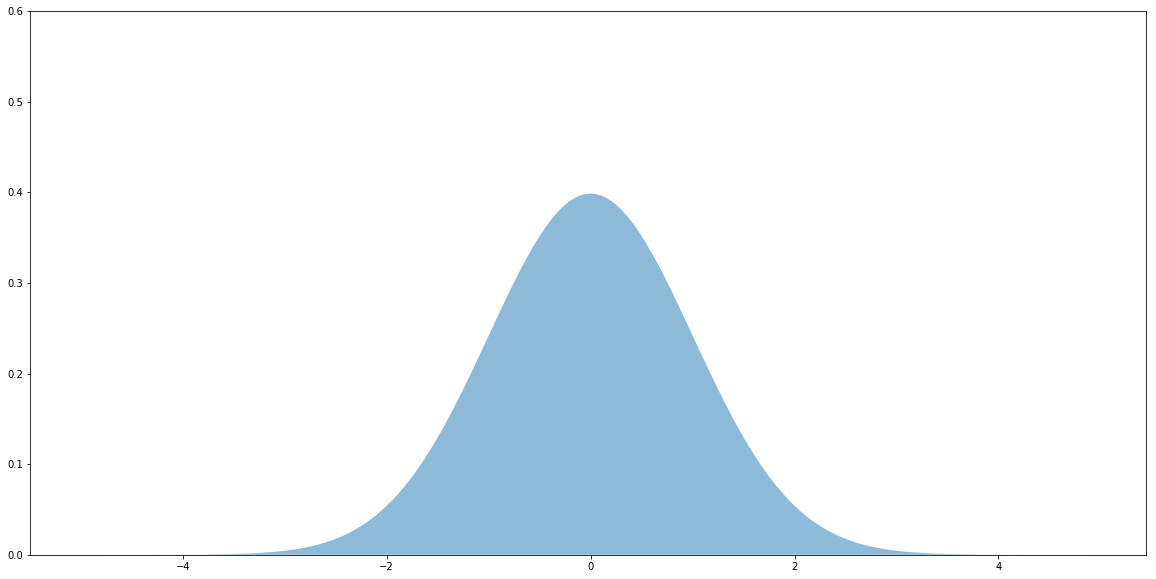

In [54]:
from sklearn.neighbors import KernelDensity

ls_error = result_ls['observed'] - result_ls['predicted']

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(ls_error[:, None])

# score_samples returns the log of the probability density
x = np.arange(-5,5,0.05)
logprob = kde.score_samples(x[:, None])

plt.fill_between(x, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(0,0.6 )
plt.rcParams['figure.figsize'] = (20.0, 10.0)
# the probability density of the errors is normal density
# Although it does not stand as a proof, it suggests every error are independant and identically distributed
# Thus, according to Markov-Gauss theorem, the least square method is BLUE


4.5793649449494


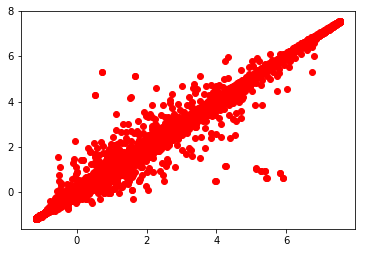

In [34]:
x = time_lag_df["var3(t-0)"]
y = time_lag_df["var3(t+2)"]
e = (y-x).max()
print(e)
plt.plot(x,y, "ro")

79.22301354762459


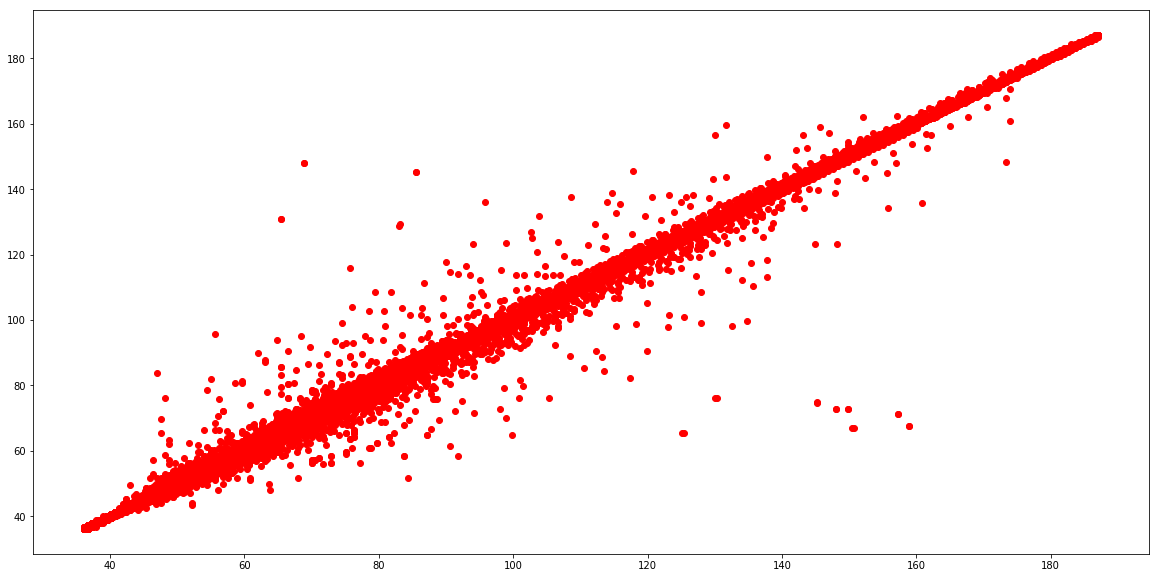

In [23]:
x = 56.5 +17.3*time_lag_df["var3(t-0)"]
y = 56.5+17.3*time_lag_df["var3(t+2)"]
e = (y-x).max()
print(e)
plt.plot(x,y, "ro")

In [12]:
interpolate_df["P8102520"].max()

205.2

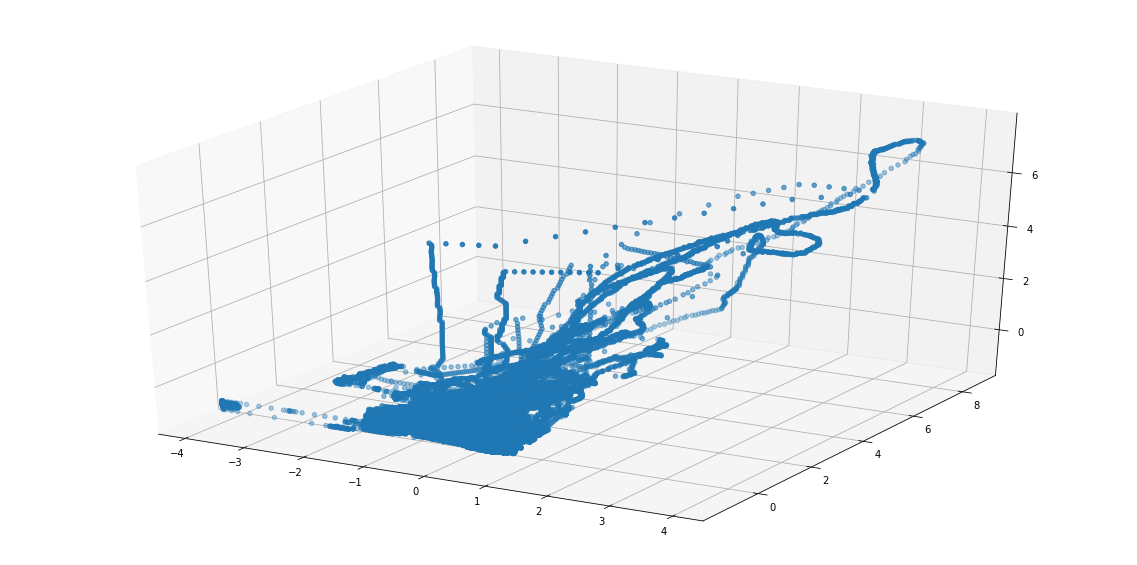

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


x1 = time_lag_df["var1(t-0)"]["2011-04-01 01:45:00":"2013-05-01 01:45:00"]
y1 = time_lag_df["var2(t-0)"]["2011-04-01 01:45:00":"2013-05-01 01:45:00"]
z1 = time_lag_df["var3(t+2)"]["2011-04-01 01:45:00":"2013-05-01 01:45:00"]

ax.scatter(x1,y1,z1)

In [28]:
print(interpolate_df)

                     P8312510    P8394310  P8462510    P8022520    P8102520
Date                                                                       
2009-12-30 01:45:00     106.0  116.150000      55.0  153.000000   68.000000
2009-12-30 02:00:00     106.0  119.400000      56.0  148.000000   71.000000
2009-12-30 02:15:00     106.0  123.433333      56.0  141.000000   73.000000
2009-12-30 02:30:00     106.0  127.466667      56.0  136.000000   75.000000
2009-12-30 02:45:00     106.0  131.500000      56.0  131.000000   77.000000
2009-12-30 03:00:00     106.0  136.000000      56.0  127.000000   79.000000
2009-12-30 03:15:00     107.0  137.950000      56.0  123.000000   81.000000
2009-12-30 03:30:00     107.0  139.900000      56.0  119.000000   84.000000
2009-12-30 03:45:00     107.0  143.100000      56.0  116.000000   86.000000
2009-12-30 04:00:00     107.0  145.100000      56.0  113.000000   89.000000
2009-12-30 04:15:00     107.0  147.100000      56.0  109.000000   92.000000
2009-12-30 0